## CSE 6242 - Team 159 Project - Diabetes Resilient Individuals


https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

## Import Libraries

In [ ]:
from ucimlrepo import fetch_ucirepo

import numpy as np  
import pandas as pd  
from scipy import stats
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate, LearningCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, f1_score, make_scorer, silhouette_score, pairwise_distances, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import joblib

import os


## Import Data

In [ ]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [8]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


## Handling Missing Values & Imbalanced Data

In [9]:
y.Diabetes_binary.value_counts()

Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64

As there is a huge difference between the target class labels, we might need to use something like SMOTE to ensure we have balanced data

In [10]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
y.Diabetes_binary.value_counts()

Diabetes_binary
0    218334
1    218334
Name: count, dtype: int64

## Use only 100,000 data points (=25% of SMOTE balanced data) to make it easy to run the models like clustering, prediction models etc

In [11]:
# Combine X and y into a single DataFrame for easier sampling
df_smote = pd.DataFrame(X)
df_smote['target'] = y

# Check the class distribution in the SMOTE data
class_distribution = df_smote['target'].value_counts(normalize=True)
print(f"Class distribution before sampling:\n{class_distribution}")

# Sample 100,000 rows while maintaining the class balance
df_smote_sampled = df_smote.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=1.0, random_state=42)).sample(n=100000, random_state=42)

# Check the class distribution of the sampled data
sampled_class_distribution = df_smote_sampled['target'].value_counts(normalize=True)
print(f"Class distribution after sampling 100,000 rows:\n{sampled_class_distribution}")

# Separate the features and target after sampling
X_sampled = df_smote_sampled.drop(columns='target')
y_sampled = df_smote_sampled['target']

X=X_sampled
y=y_sampled

Class distribution before sampling:
target
0    0.5
1    0.5
Name: proportion, dtype: float64
Class distribution after sampling 100,000 rows:
target
0    0.5004
1    0.4996
Name: proportion, dtype: float64


C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\2666986388.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smote_sampled = df_smote.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=1.0, random_state=42)).sample(n=100000, random_state=42)


## Encoding and then Split Data into training and testing

### Encoding

In [12]:
# Version 1

class MultiColumnOneHotEncoder:
    def __init__(self, columns=None):
        self.columns = columns  # array of column names to encode

    def fit(self, X, y=None):
        return self  # not relevant here

    def transform(self, X, y=None):
        '''
        Transforms columns of X specified in self.columns using
        OneHotEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                encoder = OneHotEncoder(sparse=False)
                encoded_cols = encoder.fit_transform(output[[col]])
                encoded_df = pd.DataFrame(encoded_cols, columns=[f"{col}_{i}" for i in range(encoded_cols.shape[1])], index=output.index)
                output = pd.concat([output, encoded_df], axis=1)
                output.drop(col, axis=1, inplace=True)
        else:
            for colname, col in output.iteritems():
                encoder = OneHotEncoder(sparse=False)
                encoded_cols = encoder.fit_transform(col.values.reshape(-1, 1))
                encoded_df = pd.DataFrame(encoded_cols, columns=[f"{colname}_{i}" for i in range(encoded_cols.shape[1])], index=output.index)
                output = pd.concat([output, encoded_df], axis=1)
                output.drop(colname, axis=1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

In [13]:
Num_columns=X.iloc[:,([3,13,14,15,18,19,20])].columns
Num_columns

Index(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income'], dtype='object')

## Splitting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=27,stratify=y)

In [15]:
y_train.value_counts(normalize=True)

target
0    0.5004
1    0.4996
Name: proportion, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

target
0    0.5004
1    0.4996
Name: proportion, dtype: float64

## Box Plots

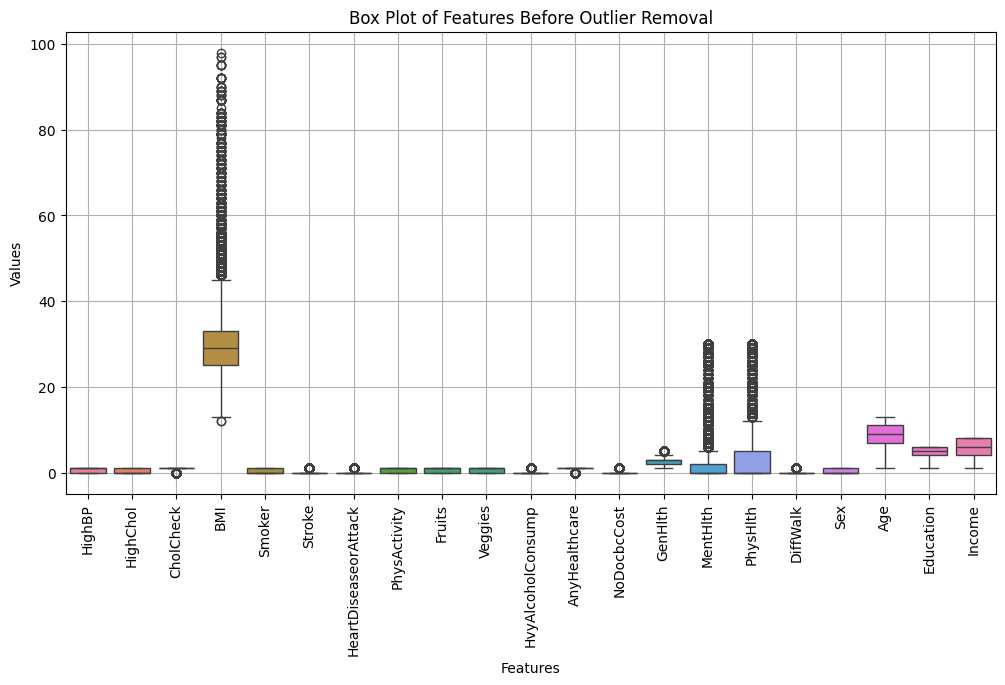

In [17]:
# Convert X_train to DataFrame if it's not already
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Create box plots for all features
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title("Box Plot of Features Before Outlier Removal")
plt.xlabel("Features")
plt.ylabel("Values")
plt.grid(True)
plt.show()

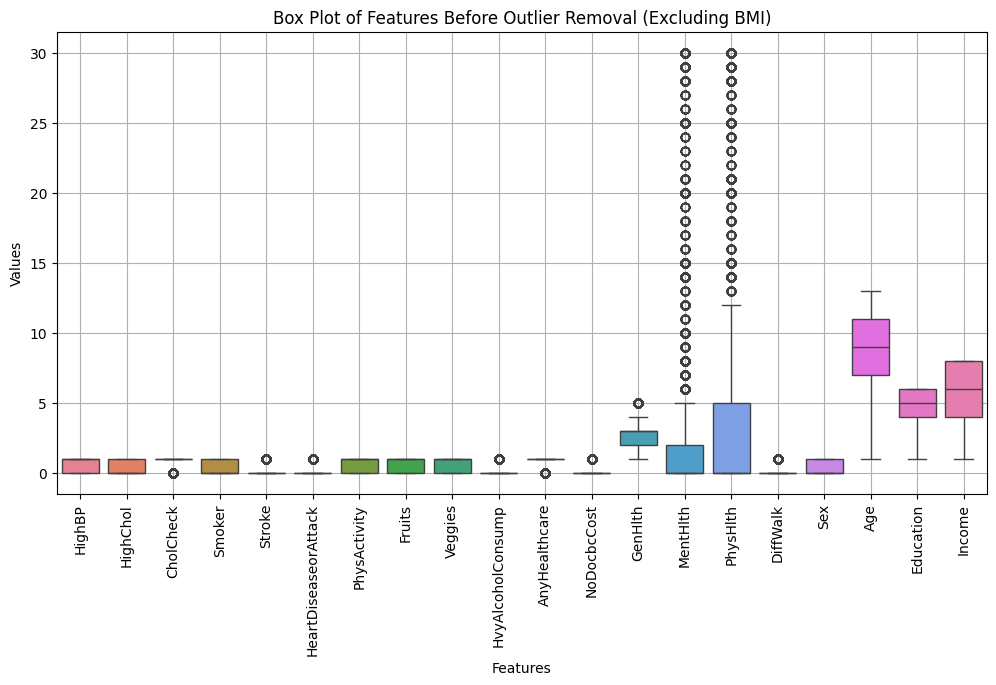

In [18]:
# Convert X_train to DataFrame if it's not already
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Drop the "BMI" column if it exists
if "BMI" in X_train_df.columns:
    X_train_df = X_train_df.drop(columns=["BMI"])

# Create box plots for all features except "BMI"
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title("Box Plot of Features Before Outlier Removal (Excluding BMI)")
plt.xlabel("Features")
plt.ylabel("Values")
plt.grid(True)
plt.show()


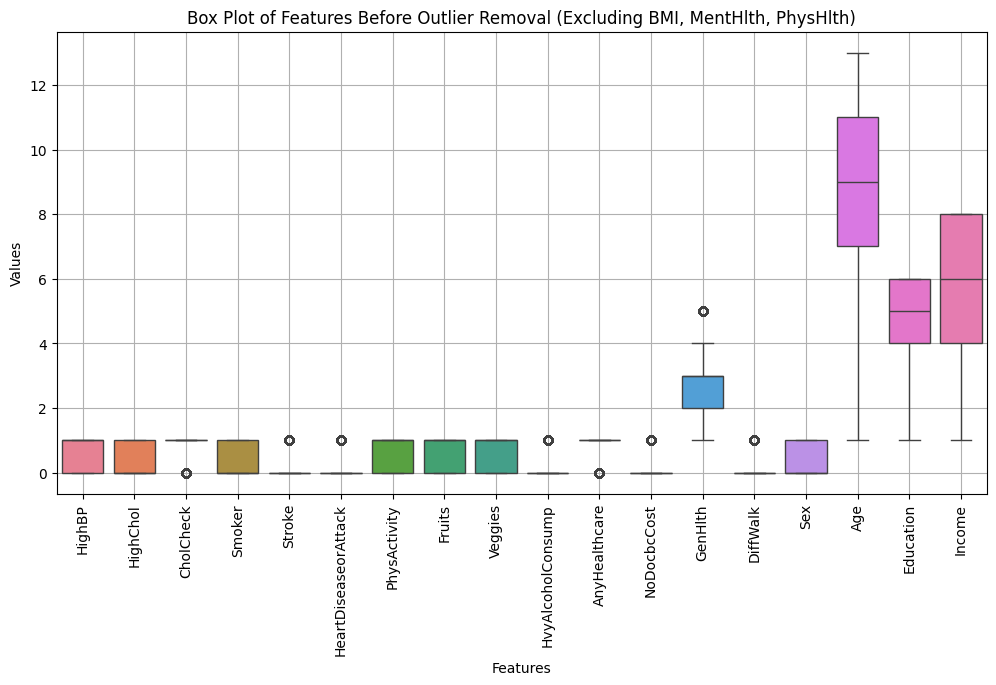

In [19]:
# Convert X_train to DataFrame if it's not already
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Drop the "BMI", "MentHlth", and "PhysHlth" columns if they exist
columns_to_exclude = ["BMI", "MentHlth", "PhysHlth"]
X_train_df = X_train_df.drop(columns=[col for col in columns_to_exclude if col in X_train_df.columns])

# Create box plots for all features except excluded columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title("Box Plot of Features Before Outlier Removal (Excluding BMI, MentHlth, PhysHlth)")
plt.xlabel("Features")
plt.ylabel("Values")
plt.grid(True)
plt.show()


## Outlier Handling - Removing Outliers

In [20]:
# Z-score method for outlier detection
z_scores = np.abs(stats.zscore(X_train))

# Set a threshold for outlier removal (common value: 3)
threshold = 3

# Identify rows where all feature Z-scores are less than the threshold
outlier_mask = (z_scores < threshold).all(axis=1)

# Filter out the rows in X and y
X_train_NoOutliers = X_train[outlier_mask]
y_train_NoOutliers = y_train[outlier_mask]

# Now X_cleaned and y_cleaned are the data with outliers removed


In [21]:
X_train_NoOutliers.shape, y_train_NoOutliers.shape

((56577, 21), (56577,))

In [22]:
X_train=X_train_NoOutliers
y_train=y_train_NoOutliers

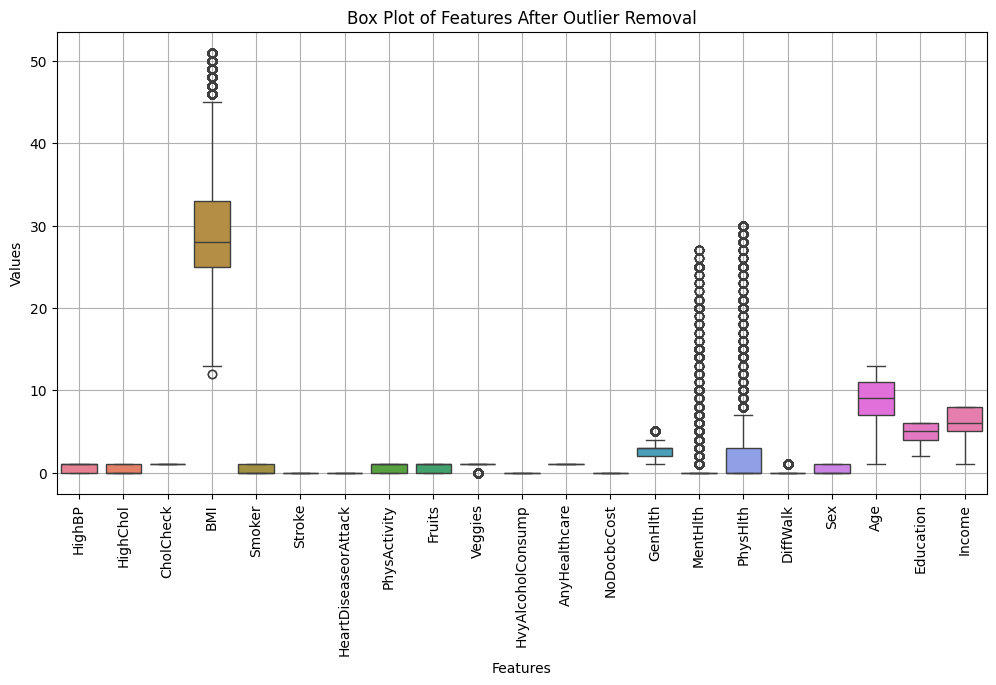

In [23]:
# Convert X_train to DataFrame if it's not already
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Create box plots for all features
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title("Box Plot of Features After Outlier Removal")
plt.xlabel("Features")
plt.ylabel("Values")
plt.grid(True)
plt.show()

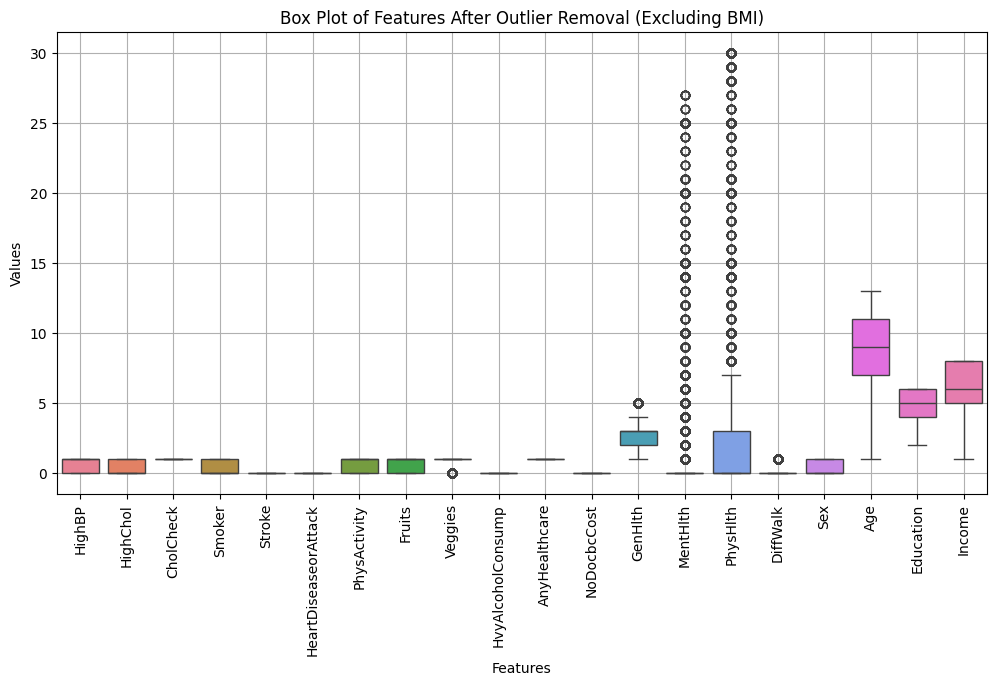

In [24]:
# Convert X_train to DataFrame if it's not already
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Drop the "BMI" column if it exists
if "BMI" in X_train_df.columns:
    X_train_df = X_train_df.drop(columns=["BMI"])

# Create box plots for all features except "BMI"
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title("Box Plot of Features After Outlier Removal (Excluding BMI)")
plt.xlabel("Features")
plt.ylabel("Values")
plt.grid(True)
plt.show()


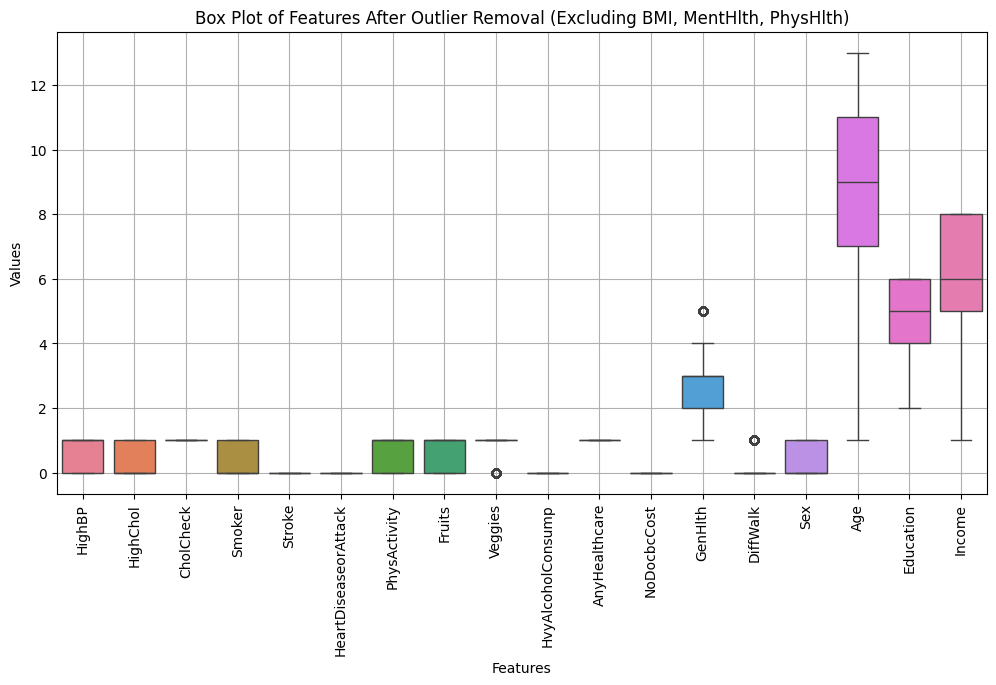

In [25]:
# Convert X_train to DataFrame if it's not already
if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Drop the "BMI", "MentHlth", and "PhysHlth" columns if they exist
columns_to_exclude = ["BMI", "MentHlth", "PhysHlth"]
X_train_df = X_train_df.drop(columns=[col for col in columns_to_exclude if col in X_train_df.columns])

# Create box plots for all features except excluded columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.title("Box Plot of Features After Outlier Removal (Excluding BMI, MentHlth, PhysHlth)")
plt.xlabel("Features")
plt.ylabel("Values")
plt.grid(True)
plt.show()


## Scaling

In [26]:

f1_weighted_score = make_scorer(f1_score, average='weighted')
import pprint
pp = pprint.PrettyPrinter(indent=4)

scaler = StandardScaler()
scaler.fit(X_train[Num_columns])


X_train[Num_columns] = scaler.transform(X_train[Num_columns])
X_test[Num_columns] = scaler.transform(X_test[Num_columns])

In [27]:
df_xy = pd.concat([X_train,y_train],axis=1)
data1=df_xy
data1_describe=data1.describe()
data1_describe

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,target
count,56577.000000,56577.000000,56577.0,5.657700e+04,56577.000000,56577.0,56577.0,56577.000000,56577.000000,56577.000000,...,56577.0,5.657700e+04,5.657700e+04,5.657700e+04,56577.000000,56577.000000,5.657700e+04,5.657700e+04,5.657700e+04,56577.000000
mean,0.510031,0.458366,1.0,-2.381160e-16,0.375011,0.0,0.0,0.688531,0.577885,0.762041,...,0.0,-1.888853e-16,-4.119307e-17,-4.973309e-17,0.155169,0.397653,1.787126e-16,3.262792e-16,-1.468131e-16,0.506266
std,0.499904,0.498268,0.0,1.000009e+00,0.484130,0.0,0.0,0.463098,0.493901,0.425838,...,0.0,1.000009e+00,1.000009e+00,1.000009e+00,0.362069,0.489417,1.000009e+00,1.000009e+00,1.000009e+00,0.499965
min,0.000000,0.000000,1.0,-2.837751e+00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,-1.627270e+00,-3.952900e-01,-4.998628e-01,0.000000,0.000000,-2.710968e+00,-2.919288e+00,-2.335375e+00,0.000000
25%,0.000000,0.000000,1.0,-7.152275e-01,0.000000,0.0,0.0,0.000000,0.000000,1.000000,...,0.0,-6.064236e-01,-3.952900e-01,-4.998628e-01,0.000000,0.000000,-5.604312e-01,-9.262439e-01,-4.274372e-01,0.000000
50%,1.000000,0.000000,1.0,-2.254143e-01,0.000000,0.0,0.0,1.000000,1.000000,1.000000,...,0.0,4.144228e-01,-3.952900e-01,-4.998628e-01,0.000000,0.000000,1.564144e-01,7.027808e-02,4.954731e-02,1.000000
75%,1.000000,1.000000,1.0,5.909410e-01,1.000000,0.0,0.0,1.000000,1.000000,1.000000,...,0.0,4.144228e-01,-3.952900e-01,-1.576398e-01,0.000000,1.000000,8.732600e-01,1.066800e+00,1.003516e+00,1.000000
max,1.000000,1.000000,1.0,3.529820e+00,1.000000,0.0,0.0,1.000000,1.000000,1.000000,...,0.0,2.456116e+00,5.986075e+00,2.922367e+00,1.000000,1.000000,1.590106e+00,1.066800e+00,1.003516e+00,1.000000


## Correlation

In [28]:
### DATA EXPLORATION CONTINUED
correlation_matrix_data1 = data1.corr()
print(correlation_matrix_data1)

                        HighBP  HighChol  CholCheck       BMI    Smoker  \
HighBP                1.000000  0.261446        NaN  0.249298  0.045914   
HighChol              0.261446  1.000000        NaN  0.107301  0.058167   
CholCheck                  NaN       NaN        NaN       NaN       NaN   
BMI                   0.249298  0.107301        NaN  1.000000 -0.017492   
Smoker                0.045914  0.058167        NaN -0.017492  1.000000   
Stroke                     NaN       NaN        NaN       NaN       NaN   
HeartDiseaseorAttack       NaN       NaN        NaN       NaN       NaN   
PhysActivity         -0.147221 -0.078950        NaN -0.211225 -0.044035   
Fruits               -0.064390 -0.057480        NaN -0.140682 -0.047752   
Veggies              -0.077588 -0.044235        NaN -0.091554 -0.004563   
HvyAlcoholConsump          NaN       NaN        NaN       NaN       NaN   
AnyHealthcare              NaN       NaN        NaN       NaN       NaN   
NoDocbcCost              

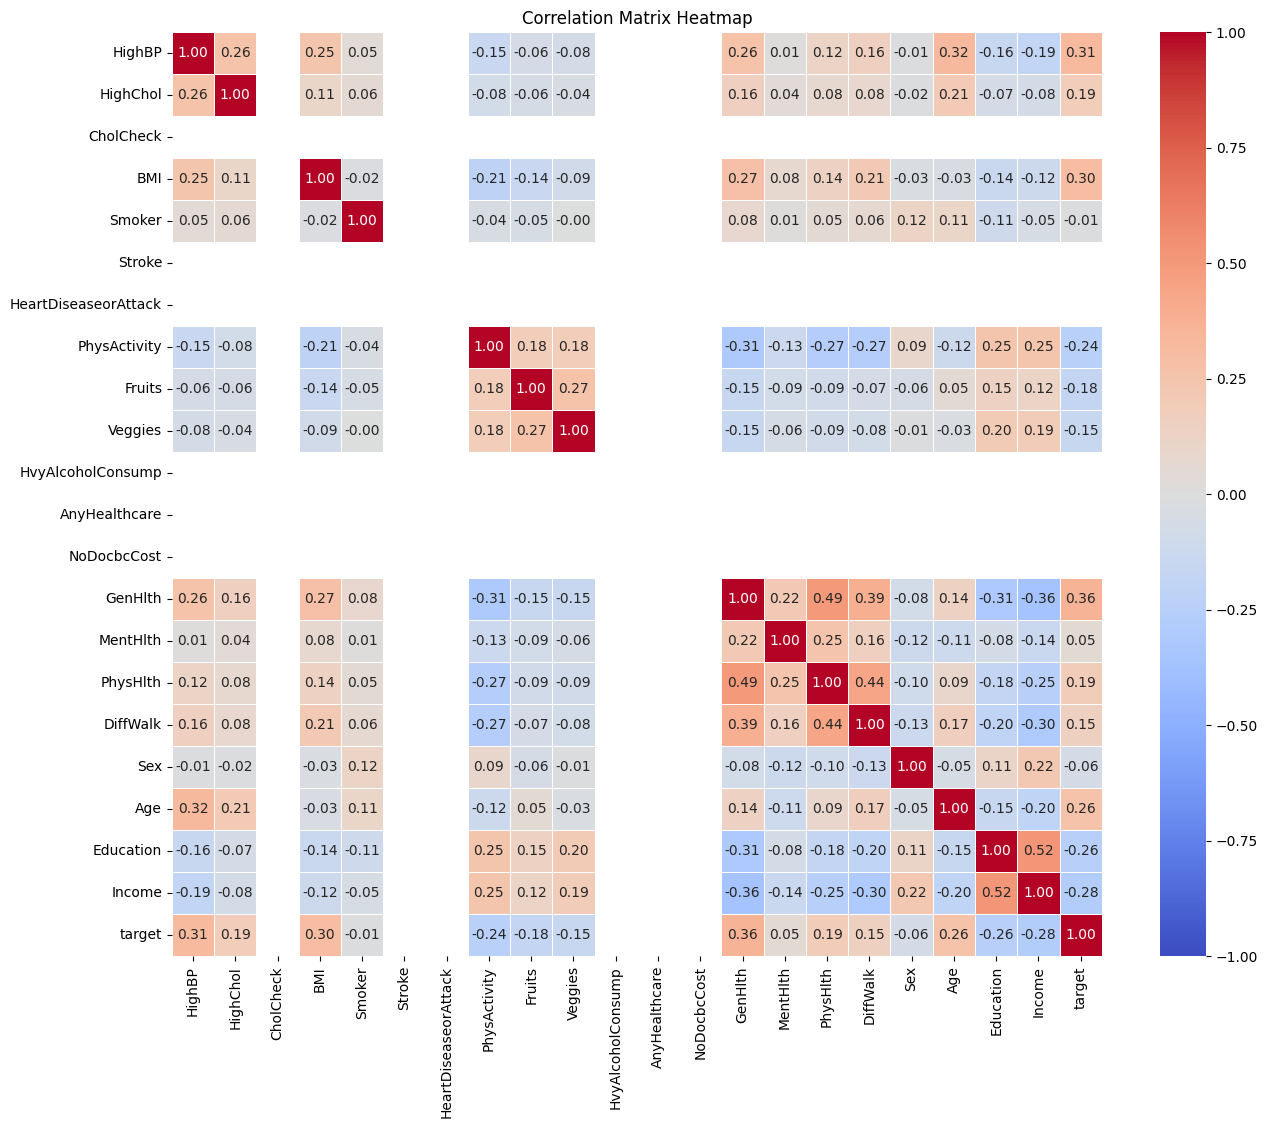

In [29]:
# Generate the heatmap
plt.figure(figsize=(15, 12))  # You can adjust the size as needed
sns.heatmap(correlation_matrix_data1, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Display the heatmap
plt.title('Correlation Matrix Heatmap')
plt.show()

## Clustering

### K Means

In [30]:
def k_means_clustering(X_train, num_clusters,random_state=42):
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    kmeans.fit(X_train)
    return kmeans

def calculate_inter_intra_distances(X_train, kmeans_model):
    inter_cluster_distances = pairwise_distances(kmeans_model.cluster_centers_)
    intra_cluster_distances = kmeans_model.inertia_
    return np.mean(inter_cluster_distances), intra_cluster_distances

def calculate_silhouette_score(X_train, kmeans_model):
    silhouette = silhouette_score(X_train, kmeans_model.labels_)
    return silhouette

def generate_plots(cluster_range, inter_distances, intra_distances, silhouette_scores):
    plt.figure(figsize=(12, 6))

    # Plot Inter Cluster Distance
    plt.subplot(2,2, 1)
    plt.plot(cluster_range, inter_distances, marker='o', linestyle='-', label='Inter-cluster Distance')
    # plt.plot(cluster_range, intra_distances, marker='o', linestyle='-', label='Intra-cluster Distance')
    plt.title('Inter Cluster Distance vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distance')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.legend()

    # Plot Intra Cluster Distance
    plt.subplot(2,2, 2)
    # plt.plot(cluster_range, inter_distances, marker='o', linestyle='-', label='Inter-cluster Distance')
    plt.plot(cluster_range, intra_distances, marker='o', linestyle='-', label='Intra-cluster Distance')
    plt.title('Intra Cluster Distance vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distance')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.legend()

    # Plot Silhouette Score
    plt.subplot(2,2, 3)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_range)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def generate_table(cluster_range, inter_distances, intra_distances,silhouette_scores):
    table_data = {'Number of Clusters': cluster_range, 'Inter-cluster Distance': inter_distances, 'Intra-cluster Distance': intra_distances,'SilhouetteScore': silhouette_scores}
    table = pd.DataFrame(table_data)
    print("Inter vs. Intra Cluster Distance Table:")
    print(table)

In [31]:
cluster_range = range(2,7)  # Range of clusters to try
inter_distances_kMbase_list=[]
intra_distances_kMbase_list=[]
silhouette_scores_kMbase=[]

# Dictionary to store cluster labels for different numbers of clusters
cluster_labels_dict = {}

for num_clusters in cluster_range:
    # Train K-means model
    kmeans_model_base = k_means_clustering(X_train, num_clusters)

    # Calculate inter and intra cluster distances
    inter_distance_kMbase, intra_distance_kMbase = calculate_inter_intra_distances(X_train, kmeans_model_base)
    inter_distances_kMbase_list.append(inter_distance_kMbase)
    intra_distances_kMbase_list.append(intra_distance_kMbase)

    # Calculate silhouette score
    silhouette_kMbase = calculate_silhouette_score(X_train, kmeans_model_base)
    silhouette_scores_kMbase.append(silhouette_kMbase)

    # Store cluster labels in the dictionary
    cluster_labels_dict[num_clusters] = kmeans_model_base.labels_

    # Print distances for each cluster
    print(f"Number of clusters: {num_clusters}")
    print("Inter-cluster Distance:", inter_distance_kMbase)
    print("Intra-cluster Distance:", intra_distance_kMbase)
    print("Silhouette Score:", silhouette_kMbase)
    print()

Number of clusters: 2
Inter-cluster Distance: 1.3342076426132727
Intra-cluster Distance: 402468.0940323773
Silhouette Score: 0.21095081966995724

Number of clusters: 3
Inter-cluster Distance: 2.0394147322159832
Intra-cluster Distance: 357046.634977072
Silhouette Score: 0.16152284565717479

Number of clusters: 4
Inter-cluster Distance: 2.188965188665804
Intra-cluster Distance: 332961.43871143216
Silhouette Score: 0.13231557510690672

Number of clusters: 5
Inter-cluster Distance: 2.778069240922788
Intra-cluster Distance: 303145.5202502731
Silhouette Score: 0.13068878253381008

Number of clusters: 6
Inter-cluster Distance: 2.417628064800813
Intra-cluster Distance: 300457.9359338487
Silhouette Score: 0.10209668630746484



In [32]:
# Find the number of clusters with the highest silhouette score
best_cluster_index = np.argmax(silhouette_scores_kMbase)  # Get index of max silhouette score
best_num_clusters = cluster_range[best_cluster_index]  # Get corresponding cluster number
best_cluster_labels = cluster_labels_dict[best_num_clusters]  # Get labels for best cluster

print(f"Best number of clusters: {best_num_clusters}")
print(f"Highest Silhouette Score: {silhouette_scores_kMbase[best_cluster_index]}")
print("Cluster labels for best number of clusters:", best_cluster_labels)


Best number of clusters: 2
Highest Silhouette Score: 0.21095081966995724
Cluster labels for best number of clusters: [0 1 1 ... 1 0 1]


In [33]:
# # Check out the Labels from the Final KMeans Model
# cluster_labels = kmeans_model_base.labels_
cluster_labels =best_cluster_labels
# cluster_labels
print("Cluster labels for",best_num_clusters, "clusters:", cluster_labels)

Cluster labels for 2 clusters: [0 1 1 ... 1 0 1]


#### (KMeans) Visualize best cluster

c:\Users\Hp\Desktop\GATech\ISYE 6242\Project\diabetes\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\Hp\Desktop\GATech\ISYE 6242\Project\diabetes\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


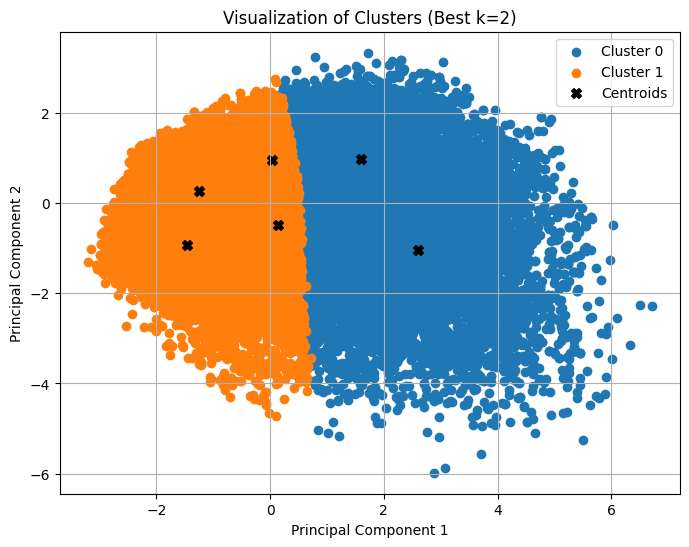

In [34]:
from sklearn.decomposition import PCA

def visualize_clusters(X_train, cluster_labels, num_clusters):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(X_train)

    plt.figure(figsize=(8, 6))
    for i in range(num_clusters):
        plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}')

    plt.scatter(pca.transform(kmeans_model_base.cluster_centers_)[:, 0],
                pca.transform(kmeans_model_base.cluster_centers_)[:, 1],
                color='black', marker='X', s=50, label='Centroids')

    plt.title(f'Visualization of Clusters (Best k={num_clusters})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_clusters(X_train, np.array(cluster_labels), best_num_clusters)


c:\Users\Hp\Desktop\GATech\ISYE 6242\Project\diabetes\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


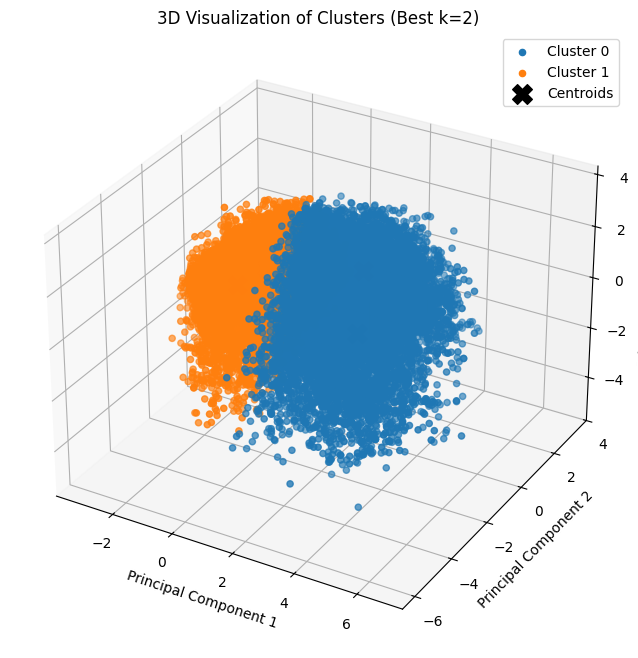

In [35]:
def visualize_clusters_3D(X_train, cluster_labels, num_clusters, kmeans_model):
    pca = PCA(n_components=3)  # Reduce data to 3D for visualization
    X_pca = pca.fit_transform(X_train)
    centroids_pca = pca.transform(kmeans_model.cluster_centers_)  # Transform centroids to 3D

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot cluster points
    for i in range(num_clusters):
        ax.scatter(X_pca[cluster_labels == i, 0],
                   X_pca[cluster_labels == i, 1],
                   X_pca[cluster_labels == i, 2],
                   label=f'Cluster {i}')

    # Plot centroids
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
               color='black', marker='X', s=200, label='Centroids')

    ax.set_title(f'3D Visualization of Clusters (Best k={num_clusters})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()

# Call the function to visualize
visualize_clusters_3D(X_train, np.array(cluster_labels), best_num_clusters, kmeans_model_base)


## (KMeans) Compare with ground truth labels

In [36]:
if not isinstance(y_train, np.ndarray):
    y_train_2 = y_train.values.ravel()

In [37]:
# Compare cluster output labels with ground truth labels

# Calculate ARI and NMI using ground truth labels and K-means cluster labels
ari = adjusted_rand_score(y_train_2, cluster_labels)
nmi = normalized_mutual_info_score(y_train_2, cluster_labels)

# Print ARI and NMI scores
print("Adjusted Rand Index:", ari)
print("Normalized Mutual Information:", nmi)

Adjusted Rand Index: 0.11158050544177822
Normalized Mutual Information: 0.09569451741616644


## Propensity Score, Causal Analysis

In [38]:
kmeans_model_base.score

<bound method _BaseKMeans.score of KMeans(n_clusters=6, random_state=42)>

In [39]:
cluster_labels

array([0, 1, 1, ..., 1, 0, 1], shape=(56577,), dtype=int32)

In [40]:
y_train

188612    0
182739    0
365892    1
431387    1
203283    0
         ..
354465    1
423470    1
91718     0
323327    1
167215    0
Name: target, Length: 56577, dtype: int64

In [41]:
y_clusters = pd.DataFrame(cluster_labels)
y_clusters

,0
0,0
1,1
2,1
3,0
4,0
...,...
56572,0
56573,0
56574,1
56575,0


In [42]:
# Can use classification algorithm such as Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [43]:
y_clusters

,0
0,0
1,1
2,1
3,0
4,0
...,...
56572,0
56573,0
56574,1
56575,0


In [44]:
prediction_probabilities_original = lr.predict_proba(X_test)
prediction_probabilities_original

array([[0.12192221, 0.87807779],
       [0.60251805, 0.39748195],
       [0.93194242, 0.06805758],
       ...,
       [0.55714897, 0.44285103],
       [0.69921522, 0.30078478],
       [0.58376738, 0.41623262]], shape=(20000, 2))

In [45]:
prediction_series = prediction_probabilities_original.reshape(-1)

In [46]:
propensity_df = pd.DataFrame({'propensity_score_original': prediction_series})
propensity_df

,propensity_score_original
0,0.121922
1,0.878078
2,0.602518
3,0.397482
4,0.931942
...,...
39995,0.442851
39996,0.699215
39997,0.300785
39998,0.583767


## Identifying high risk factors

https://medium.com/@zainab.mehmood/exploratory-data-analysis-of-diabetes-health-indicators-39a0d5c4aa1a

In [47]:
# Define independent variables and target
U = df_xy[['Age', 'BMI', 'PhysActivity', 'HighBP', 'HighChol']]
v = df_xy['target']

# Add constant to the model
U = sm.add_constant(U)

# Fit logistic regression model
model = sm.Logit(v, U).fit()

# Display model summary
print(model.summary())

# print(U)


Optimization terminated successfully.
         Current function value: 0.572661
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                56577
Model:                          Logit   Df Residuals:                    56571
Method:                           MLE   Df Model:                            5
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.1737
Time:                        21:13:17   Log-Likelihood:                -32399.
converged:                       True   LL-Null:                       -39212.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0454      0.022      2.074      0.038       0.002       0.088
Age              0.4912

## Resilient Individuals

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


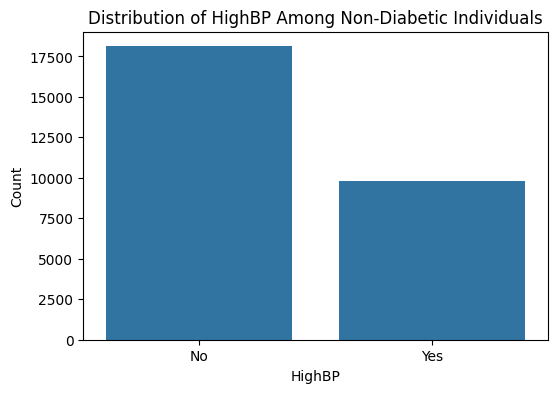

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


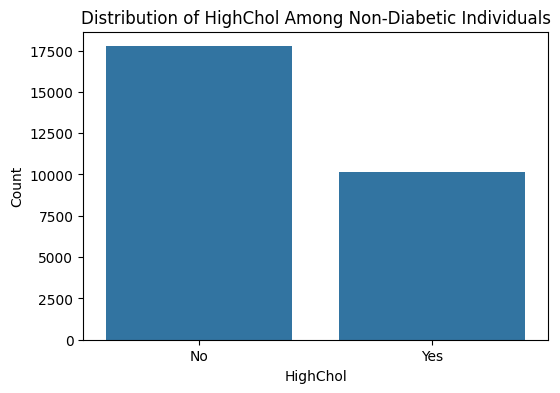

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


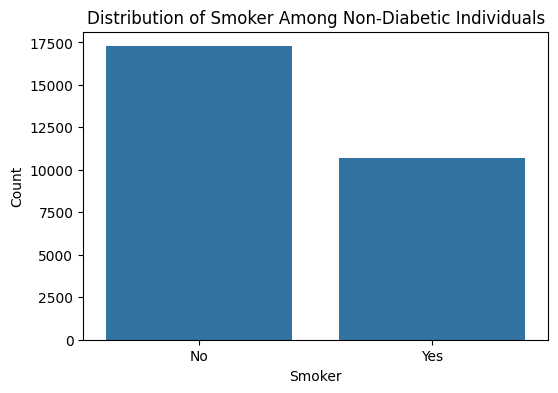

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


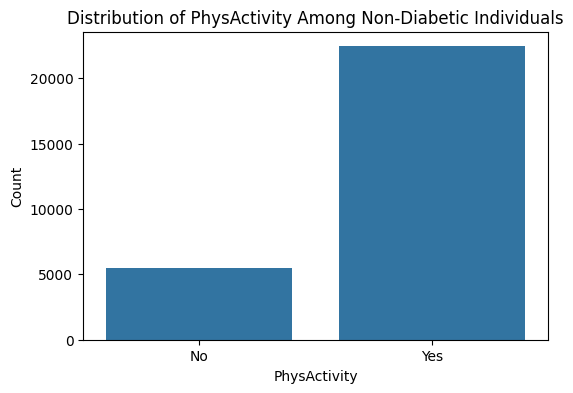

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


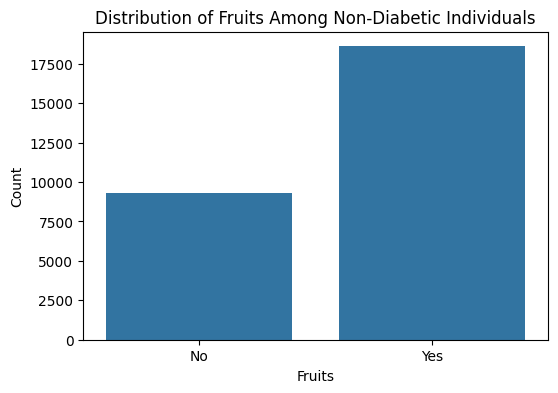

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


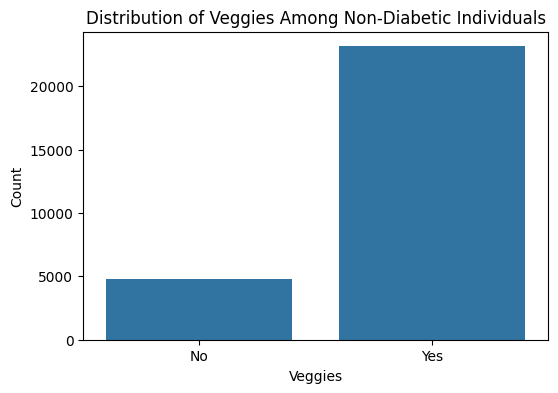

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


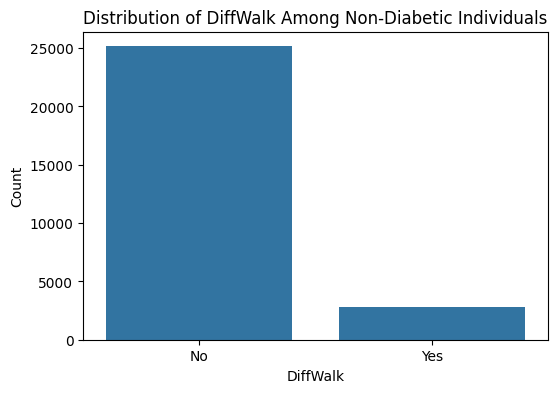

C:\Users\Hp\AppData\Local\Temp\ipykernel_19140\3420842809.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['0 (Female)', '1 (Male)'])


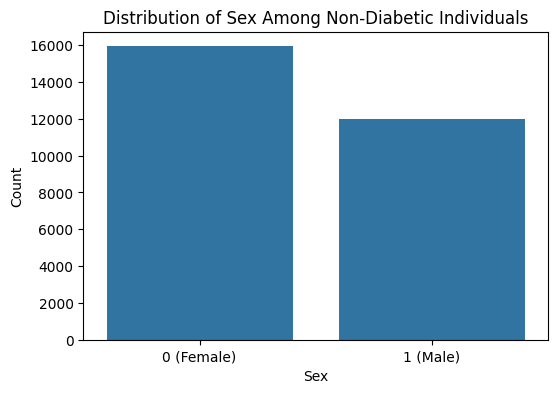

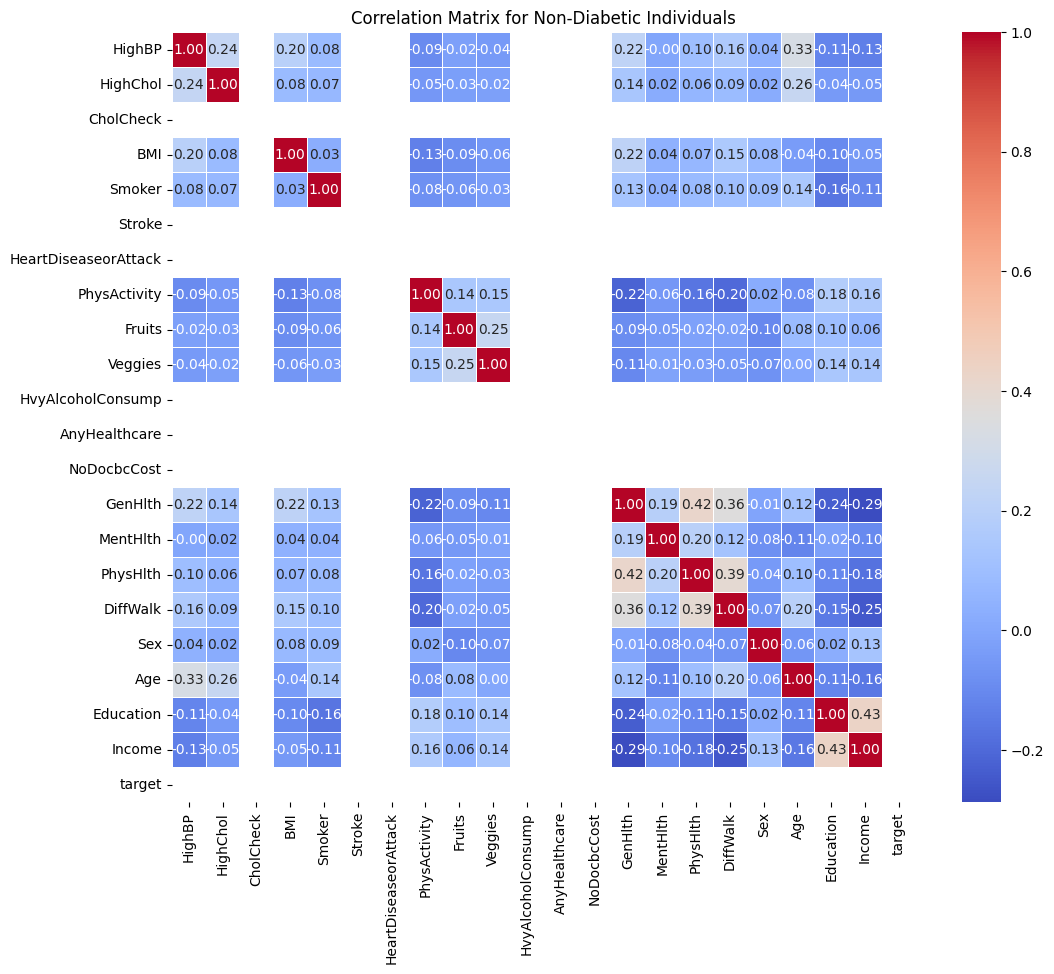

In [48]:
# Load the dataset
# df = pd.read_csv('diabetes_health_indicators.csv')

# Filter for non-diabetic individuals
non_diabetic_df = df_xy[df_xy['target'] == 0]

# Identify binary (0/1) features
binary_features = [col for col in non_diabetic_df.columns if non_diabetic_df[col].nunique() == 2]

# 1. Bar charts for binary features
for feature in binary_features:
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=feature, data=non_diabetic_df)
    plt.title(f'Distribution of {feature} Among Non-Diabetic Individuals')
    plt.xlabel(feature)
    plt.ylabel('Count')

    # Special handling for 'Sex' feature
    if feature == 'Sex':
        ax.set_xticklabels(['0 (Female)', '1 (Male)'])
    else:
        ax.set_xticklabels(['No', 'Yes'])

    plt.show()

# 2. Correlation heatmap for all features
plt.figure(figsize=(12, 10))
correlation_matrix = non_diabetic_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Non-Diabetic Individuals')
plt.show()


## Analyzing Resilient Individuals

In [49]:
# Define high-risk criteria
high_risk_non_diabetic = df_xy[
    (df_xy['Age'] > 60) &
    (df_xy['BMI'] > 30) &
    (df_xy['PhysActivity'] == 0) &
    (df_xy['target'] == 0)
]

# Analyze the high-risk non-diabetic group
print(high_risk_non_diabetic.describe())

       HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
count     0.0       0.0        0.0  0.0     0.0     0.0                   0.0   
mean      NaN       NaN        NaN  NaN     NaN     NaN                   NaN   
std       NaN       NaN        NaN  NaN     NaN     NaN                   NaN   
min       NaN       NaN        NaN  NaN     NaN     NaN                   NaN   
25%       NaN       NaN        NaN  NaN     NaN     NaN                   NaN   
50%       NaN       NaN        NaN  NaN     NaN     NaN                   NaN   
75%       NaN       NaN        NaN  NaN     NaN     NaN                   NaN   
max       NaN       NaN        NaN  NaN     NaN     NaN                   NaN   

       PhysActivity  Fruits  Veggies  ...  NoDocbcCost  GenHlth  MentHlth  \
count           0.0     0.0      0.0  ...          0.0      0.0       0.0   
mean            NaN     NaN      NaN  ...          NaN      NaN       NaN   
std             NaN     NaN      NaN  .

# Random Forest

In [50]:
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

c:\Users\Hp\Desktop\GATech\ISYE 6242\Project\diabetes\venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [51]:
model_predictions = rfc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, model_predictions)}")
print(f"Confusion Matrix: {confusion_matrix(y_test, model_predictions)}")

Accuracy: 0.860631504257332
Confusion Matrix: [[42436  1303]
 [ 5768  1229]]


In [52]:
# Export

model_dir = os.path.join('..', 'models')
model_path = os.path.join(model_dir, 'random_forest_model.pkl')

joblib.dump(rfc, model_path) 

['..\\models\\random_forest_model.pkl']